<a href="https://colab.research.google.com/github/hima111997/Face-Classifier/blob/master/face_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Classifier (Male - Female)

* This model is for face classification (Male or Female)
* Method:
  * Celeb_a dataset were downloaded from Kaggle website (https://www.kaggle.com/jessicali9530/celeba-dataset) using Kaggle API then extracted

  * Three folders were created (Train - Valid - Test) each one with two folders (0: Female, 1:Male)
  * images were copied to the corresponding folder using the data from list_eval_partition.csv and list_attr_celeba.csv files
  * A CNN models was created
  * Transfer learning using DenseNet121, InceptionV3, and ResNet50V2 were tried. the best result was for ResNet50V2
  * metrics were calculated:    
    * confusion matrix
    * recall
    * precision
    * F1-score

* if you have any comments to improve this model, please tell me. I'm still learninig

# Downloading files

In [0]:
!mkdir /root/.kaggle
!mkdir /content/.kaggle
import json
token = {'username':'ibrahimohamed','key':'84672b6ed3b33745eeb4e082de80350d'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json    
!ls  /root/.kaggle
!kaggle config set -n path -v/content

kaggle.json
- path is now set to: /content


# Extracting files

In [0]:
import shutil
import zipfile, os

!kaggle datasets download -d jessicali9530/celeba-dataset

with zipfile.ZipFile('/content/datasets/jessicali9530/celeba-dataset/celeba-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/images')

 99% 1.32G/1.33G [00:11<00:00, 147MB/s]
100% 1.33G/1.33G [00:11<00:00, 126MB/s]


In [0]:
path = '/content/images/img_align_celeba/img_align_celeba'
files = os.listdir(path)
len(files)

202599

# Copying files to folders

In [0]:
os.mkdir('/content/images/train')
os.mkdir('/content/images/train/1') # male
os.mkdir('/content/images/train/0') # female

os.mkdir('/content/images/valid')
os.mkdir('/content/images/valid/1')
os.mkdir('/content/images/valid/0')

os.mkdir('/content/images/test')
os.mkdir('/content/images/test/1')
os.mkdir('/content/images/test/0')

In [0]:
import os, shutil, time
import pandas as pd

path = '/content/images/img_align_celeba/img_align_celeba/'
files = os.listdir(path)
attr = pd.read_csv('/content/images/list_attr_celeba.csv')
partitioning = pd.read_csv('/content/images/list_eval_partition.csv')
males = attr[['Male','image_id']]
train_names = partitioning[partitioning['partition'] == 0]['image_id'].values
valid_names = partitioning[partitioning['partition'] == 1]['image_id'].values
i = 0
start = time.time()
for file in files:
  i+=1
  if file in train_names:
    if (males[males['image_id'] == file]['Male'].values[0] == 1) == True:
      shutil.copy2(path + file, '/content/images/train/1')
    else:
      shutil.copy2(path + file, '/content/images/train/0')

    
  elif file in valid_names:
    
    if (males[males['image_id'] == file]['Male'].values[0] == 1) == True:
      shutil.copy2(path + file, '/content/images/valid/1')
    else:
      shutil.copy2(path + file, '/content/images/valid/0')    
    
  else:
    
    if (males[males['image_id'] == file]['Male'].values[0] == 1) == True:
      shutil.copy2(path + file, '/content/images/test/1')
    else:
      shutil.copy2(path + file, '/content/images/test/0')    
  if i%50000 == 0:
    print(i)
end = time.time()
print(end-start)

50000
100000
150000
200000
2872.881016254425


In [0]:
print(len(os.listdir('/content/images/test/0')))
print(len(os.listdir('/content/images/test/1')))

print(len(os.listdir('/content/images/train/0')))
print(len(os.listdir('/content/images/train/1')))

print(len(os.listdir('/content/images/valid/0')))
print(len(os.listdir('/content/images/valid/1')))

12247
7715
94509
68261
11409
8458


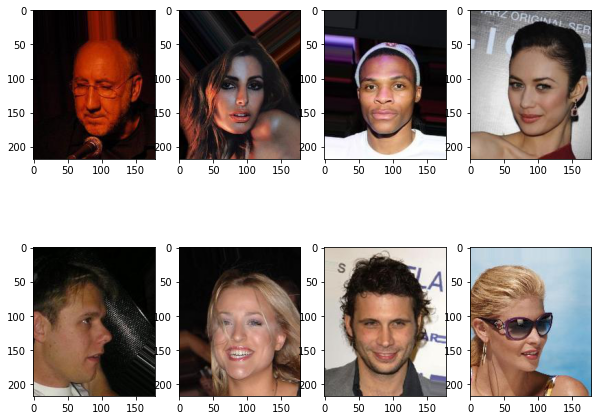

In [0]:
import matplotlib.pyplot as plt
import os

female_files = os.listdir('/content/images/train/0')
male_files = os.listdir('/content/images/train/1')
plt.figure(figsize = (10,8))
for i in range(4):  
  plt.subplot(2, 4, i*2 +1)
  plt.imshow(plt.imread('/content/images/train/1/' + male_files[i]))
  #plt.show()
  plt.subplot(2, 4, i*2 +2)
  plt.imshow(plt.imread('/content/images/train/0/' + female_files[i]))
  #plt.show()


# creating ImageDataGenerators

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255.,
                               horizontal_flip = True,
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3]
                               )

valid_gen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_gen.flow_from_directory('/content/images/train',
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode = 'binary')

valid_generator = valid_gen.flow_from_directory('/content/images/valid',
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode = 'binary')


Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.


# Creating Model and starting training

In [0]:
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform
import datetime
%load_ext tensorboard

inputs = Input(shape = (64,64,3))
X = layers.ZeroPadding2D((3,3))(inputs) # 70

X = layers.Conv2D(64, (7,7), strides = 1, padding = 'same', input_shape = (64,64,3), kernel_initializer = glorot_uniform(seed = 0))(X) #70
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 34

X = layers.Conv2D(128, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 34
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 16

X = layers.Conv2D(256, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 16
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 7

X = layers.Conv2D(512, (3,3), strides = 1, padding = 'same', kernel_initializer = glorot_uniform(seed = 0))(X) # 7
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D((3,3), (2,2))(X) # 3

X = layers.Conv2D(1024, (2,2), strides = 1, padding = 'same')(X) # 3
X = layers.AveragePooling2D(2, strides = (2,2))(X) # 1


X = layers.Flatten()(X) # 1024
X = layers.Dense(512, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(256, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(128, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(1, activation = 'sigmoid')(X)



log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = inputs, outputs = X)
#model.summary()


optim = optimizers.Adam(lr = .001)
model.compile(optimizer = optim,
              loss = 'binary_crossentropy',
              metrics=['accuracy',
                         Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= .95 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()

model.fit(train_generator,
                    epochs = 5,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/5
   3/5087 [..............................] - ETA: 1:46:14 - loss: 2.2864 - accuracy: 0.5312 - recall_5: 0.4750 - precision_5: 0.4419 - auc_9: 0.5112 - auc_10: 0.4056

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.291353). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


5087/5087 [==============================] - 725s 143ms/step - loss: 0.7048 - accuracy: 0.5780 - recall_5: 0.0139 - precision_5: 0.4093 - auc_9: 0.5022 - auc_10: 0.4208 - val_loss: 0.6774 - val_accuracy: 0.5743 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00 - val_auc_9: 0.5000 - val_auc_10: 0.4257
Epoch 2/5
5087/5087 [==============================] - 721s 142ms/step - loss: 0.4219 - accuracy: 0.7718 - recall_5: 0.5220 - precision_5: 0.8874 - auc_9: 0.8648 - auc_10: 0.8350 - val_loss: 0.1371 - val_accuracy: 0.9513 - val_recall_5: 0.9738 - val_precision_5: 0.9170 - val_auc_9: 0.9907 - val_auc_10: 0.9867
Epoch 3/5
5087/5087 [==============================] - 717s 141ms/step - loss: 0.1457 - accuracy: 0.9497 - recall_5: 0.9483 - precision_5: 0.9330 - auc_9: 0.9868 - auc_10: 0.9804 - val_loss: 0.0724 - val_accuracy: 0.9633 - val_recall_5: 0.9904 - val_precision_5: 0.9282 - val_auc_9: 0.9958 - val_auc_10: 0.9929
Epoch 4/5
5087/5087 [==============================] - 719s 141ms/ste

In [0]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 70, 70, 64)        9472      
_________________________________________________________________
batch_normalization_41 (Batc (None, 70, 70, 64)        256       
_________________________________________________________________
activation_41 (Activation)   (None, 70, 70, 64)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 34, 34, 128)       738

# continuing the training

In [0]:
model.fit(train_generator,
                    epochs = 15,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

Epoch 1/15
   3/5087 [..............................] - ETA: 26:49 - loss: 0.1365 - accuracy: 0.9583 - recall_5: 0.9556 - precision_5: 0.9556 - auc_9: 0.9861 - auc_10: 0.9701

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.143318). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


5087/5087 [==============================] - 720s 141ms/step - loss: 0.1039 - accuracy: 0.9653 - recall_5: 0.9590 - precision_5: 0.9582 - auc_9: 0.9926 - auc_10: 0.9892 - val_loss: 0.0439 - val_accuracy: 0.9732 - val_recall_5: 0.9571 - val_precision_5: 0.9795 - val_auc_9: 0.9968 - val_auc_10: 0.9962
Epoch 2/15
5087/5087 [==============================] - 719s 141ms/step - loss: 0.0977 - accuracy: 0.9670 - recall_5: 0.9606 - precision_5: 0.9607 - auc_9: 0.9935 - auc_10: 0.9906 - val_loss: 0.0585 - val_accuracy: 0.9769 - val_recall_5: 0.9670 - val_precision_5: 0.9786 - val_auc_9: 0.9976 - val_auc_10: 0.9970
Epoch 3/15
5087/5087 [==============================] - 719s 141ms/step - loss: 0.0959 - accuracy: 0.9670 - recall_5: 0.9629 - precision_5: 0.9587 - auc_9: 0.9938 - auc_10: 0.9910 - val_loss: 0.0246 - val_accuracy: 0.9792 - val_recall_5: 0.9842 - val_precision_5: 0.9675 - val_auc_9: 0.9978 - val_auc_10: 0.9973
Epoch 4/15
5087/5087 [==============================] - 720s 142ms/step - l

In [0]:
model.save('/content/drive/My Drive/face_classifier')

In [0]:
from tensorflow.keras.models import load_model
new_mod = load_model('/content/drive/My Drive/face_classifier')

# Testing the model

In [0]:
test_gen = ImageDataGenerator(rescale = 1/255.)

test_generator = train_gen.flow_from_directory('/content/images/test',
                                                target_size=(64, 64),
                                                shuffle = False,
                                                 #batch_size=32,
                                                 class_mode = 'binary')


Found 19962 images belonging to 2 classes.


Instructions for updating:
Please use Model.predict, which supports generators.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


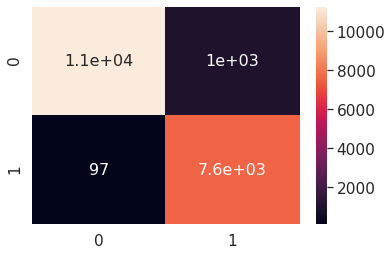

precision: 0.8842716192687173
recall: 0.9874270900842514
f1_score: 0.9330067360685855


In [0]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


probabilities = new_mod.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

In [0]:
df_cm

,0,1
0,11250,997
1,97,7618


# trying to increase the accuracy

In [0]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform
import datetime
%load_ext tensorboard

model = load_model('/content/drive/My Drive/face_classifier_V3')

log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > .98 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()

model.fit(train_generator,
                    epochs = 15,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call],
                    verbose = 0)

Epoch 1/15
5087/5087 [==============================] - 606s 119ms/step - loss: 0.0795 - accuracy: 0.9738 - recall_5: 0.9664 - precision_5: 0.9709 - auc_9: 0.9958 - auc_10: 0.9937 - val_loss: 0.0521 - val_accuracy: 0.9813 - val_recall_5: 0.9756 - val_precision_5: 0.9803 - val_auc_9: 0.9983 - val_auc_10: 0.9978
Epoch 2/15
5087/5087 [==============================] - 604s 119ms/step - loss: 0.0754 - accuracy: 0.9744 - recall_5: 0.9669 - precision_5: 0.9718 - auc_9: 0.9961 - auc_10: 0.9942 - val_loss: 0.0615 - val_accuracy: 0.9807 - val_recall_5: 0.9849 - val_precision_5: 0.9702 - val_auc_9: 0.9984 - val_auc_10: 0.9979
Epoch 3/15
5087/5087 [==============================] - 602s 118ms/step - loss: 0.0741 - accuracy: 0.9741 - recall_5: 0.9686 - precision_5: 0.9696 - auc_9: 0.9961 - auc_10: 0.9944 - val_loss: 0.0525 - val_accuracy: 0.9832 - val_recall_5: 0.9760 - val_precision_5: 0.9844 - val_auc_9: 0.9986 - val_auc_10: 0.9981
Epoch 4/15
5087/5087 [==============================] - 603s 118

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Found 19962 images belonging to 2 classes.


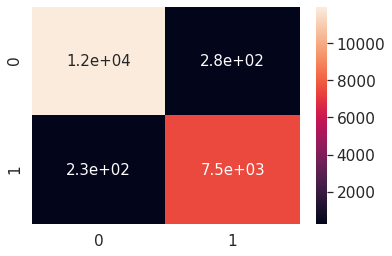

precision: 0.9644192342400413
recall: 0.9696694750486066
f1_score: 0.967037228541882


In [0]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

test_gen = ImageDataGenerator(rescale = 1/255.)

test_generator = train_gen.flow_from_directory('/content/images/test',
                                                target_size=(64, 64),
                                                shuffle = False,
                                                 #batch_size=32,
                                                 class_mode = 'binary')

probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

In [0]:
#     0    1
# 0	11971	276
# 1  234	7481

df_cm

,0,1
0,11971,276
1,234,7481


In [0]:
model.save('/content/drive/My Drive/face_classifier_V4')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/face_classifier_V3/assets


# Trying Transfer Leaerning


## DenseNet121

In [0]:
from tensorflow.keras.applications import DenseNet121

tl_model = DenseNet121(include_top = False,
                       weights='imagenet',
                       input_shape = (64,64,3),
                       )

tl_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
_______________________

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform
import datetime
%load_ext tensorboard

train_gen = ImageDataGenerator(rescale = 1/255.,
                               horizontal_flip = True,
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3]
                               )

valid_gen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_gen.flow_from_directory('/content/images/train',
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode = 'binary')

valid_generator = valid_gen.flow_from_directory('/content/images/valid',
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode = 'binary')


tl_model.trainable = False

last_layer = tl_model.output

X = layers.GlobalAveragePooling2D()(last_layer)
X = layers.Flatten()(X) # 1024
X = layers.Dense(512, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(256, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(128, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(1, activation = 'sigmoid')(X)



log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = tl_model.input, outputs = X)
model.summary()


optim = optimizers.Adam(lr = .001)
model.compile(optimizer = optim,
              loss = 'binary_crossentropy',
              metrics=['accuracy',
                         Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= .97 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()

model.fit(train_generator,
                    epochs = 5,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
_______

In [0]:
model.fit(train_generator,
                    epochs = 15,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

Epoch 1/15
5087/5087 [==============================] - 606s 119ms/step - loss: 0.3125 - accuracy: 0.8733 - recall: 0.8535 - precision: 0.8458 - auc: 0.9410 - auc_1: 0.9190 - val_loss: 0.2524 - val_accuracy: 0.9008 - val_recall: 0.8724 - val_precision: 0.8922 - val_auc: 0.9654 - val_auc_1: 0.9540
Epoch 2/15
5087/5087 [==============================] - 607s 119ms/step - loss: 0.3122 - accuracy: 0.8738 - recall: 0.8534 - precision: 0.8469 - auc: 0.9413 - auc_1: 0.9183 - val_loss: 0.2386 - val_accuracy: 0.9006 - val_recall: 0.8749 - val_precision: 0.8899 - val_auc: 0.9657 - val_auc_1: 0.9538
Epoch 3/15
5087/5087 [==============================] - 605s 119ms/step - loss: 0.3088 - accuracy: 0.8751 - recall: 0.8582 - precision: 0.8461 - auc: 0.9422 - auc_1: 0.9201 - val_loss: 0.2505 - val_accuracy: 0.9012 - val_recall: 0.8811 - val_precision: 0.8862 - val_auc: 0.9654 - val_auc_1: 0.9535
Epoch 4/15
5087/5087 [==============================] - 607s 119ms/step - loss: 0.3087 - accuracy: 0.8751 

KeyboardInterrupt: ignored

### training all the layers

In [0]:
from tensorflow.keras.applications import DenseNet121

tl_model = DenseNet121(include_top = False,
                       weights='imagenet',
                       input_shape = (200,200,3),
                       )

tl_model.summary()

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform
import datetime
%load_ext tensorboard

train_gen = ImageDataGenerator(rescale = 1/255.,
                               horizontal_flip = True,
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3]
                               )

valid_gen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_gen.flow_from_directory('/content/images/train',
                                                 target_size=(200, 200),
                                                 batch_size=32,
                                                 class_mode = 'binary')

valid_generator = valid_gen.flow_from_directory('/content/images/valid',
                                                 target_size=(200, 200),
                                                 batch_size=32,
                                                 class_mode = 'binary')


tl_model.trainable = True

last_layer = tl_model.output

X = layers.GlobalAveragePooling2D()(last_layer)
X = layers.Flatten()(X) # 1024
X = layers.Dense(512, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(256, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(128, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu')(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(1, activation = 'sigmoid')(X)



log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = tl_model.input, outputs = X)
model.summary()


optim = optimizers.Adam(lr = .001)
model.compile(optimizer = optim,
              loss = 'binary_crossentropy',
              metrics=['accuracy',
                         Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= .97 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()

model.fit(train_generator,
                    epochs = 5,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

## Inception V3

In [0]:
from tensorflow.keras.applications import InceptionV3

pre_trained_model = InceptionV3(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = 'imagenet')
pre_trained_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255.,
                               horizontal_flip = True,
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3]
                               )

valid_gen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_gen.flow_from_directory('/content/images/train',
                                                 target_size=(200, 200),
                                                 batch_size=32,
                                                 class_mode = 'binary')

valid_generator = valid_gen.flow_from_directory('/content/images/valid',
                                                 target_size=(200, 200),
                                                 batch_size=32,
                                                 class_mode = 'binary')

In [0]:

from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform

import datetime
%load_ext tensorboard



pre_trained_model.trainable = False # freezing all layers. if you want to freeze some of them select them or use for loop

#pre_trained_model.summary()
last_layer = pre_trained_model.output

X = layers.GlobalAveragePooling2D()(last_layer)
X = layers.Flatten()(X) # 2048
X = layers.Dense(1000, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(500, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(250, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)

log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = pre_trained_model.input, outputs = X)
#model.summary()


optim = optimizers.Adam(lr = .001)
model.compile(optimizer = optim,
              loss = 'binary_crossentropy',
              metrics=['accuracy',
                         Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= .97 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()

model.fit(train_generator,
                    epochs = 15,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Ac

### Trying to Train all the layers

In [0]:
from tensorflow.keras.applications import InceptionV3

pre_trained_model = InceptionV3(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255.,
                               horizontal_flip = True,
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3]
                               )

valid_gen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_gen.flow_from_directory('/content/images/train',
                                                 target_size=(200, 200),
                                                 batch_size=32,
                                                 class_mode = 'binary')

valid_generator = valid_gen.flow_from_directory('/content/images/valid',
                                                 target_size=(200, 200),
                                                 batch_size=32,
                                                 class_mode = 'binary')

Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.


In [0]:
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform

import datetime
%load_ext tensorboard



pre_trained_model.trainable = True # unfreezing all layers. if you want to freeze some of them select them or use for loop

#pre_trained_model.summary()
last_layer = pre_trained_model.output

X = layers.GlobalAveragePooling2D()(last_layer)
X = layers.Flatten()(X) # 2048
X = layers.Dense(1000, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(500, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(250, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)

log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = pre_trained_model.input, outputs = X)
#model.summary()


optim = optimizers.Adam(lr = .001)
model.compile(optimizer = optim,
              loss = 'binary_crossentropy',
              metrics=['accuracy',
                         Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= .97 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()

model.fit(train_generator,
                    epochs = 5,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

Epoch 1/5
5087/5087 [==============================] - 1865s 367ms/step - loss: 0.1439 - accuracy: 0.9487 - recall: 0.9392 - precision: 0.9385 - auc: 0.9873 - auc_1: 0.9815 - val_loss: 0.1620 - val_accuracy: 0.9454 - val_recall: 0.9891 - val_precision: 0.8940 - val_auc: 0.9899 - val_auc_1: 0.9830
Epoch 2/5
5087/5087 [==============================] - 1896s 373ms/step - loss: 0.0970 - accuracy: 0.9686 - recall: 0.9635 - precision: 0.9616 - auc: 0.9937 - auc_1: 0.9907 - val_loss: 0.9946 - val_accuracy: 0.9737 - val_recall: 0.9570 - val_precision: 0.9809 - val_auc: 0.9881 - val_auc_1: 0.9871
Epoch 3/5
5087/5087 [==============================] - 1862s 366ms/step - loss: 0.0901 - accuracy: 0.9708 - recall: 0.9661 - precision: 0.9644 - auc: 0.9944 - auc_1: 0.9917 - val_loss: 0.0832 - val_accuracy: 0.9695 - val_recall: 0.9392 - val_precision: 0.9887 - val_auc: 0.9965 - val_auc_1: 0.9964


In [0]:
model.save('/content/drive/My Drive/Inception_fully_trained')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Inception_fully_trained/assets


#### Testing

In [0]:
from tensorflow.keras.models import load_model

fully_trained = load_model('/content/drive/My Drive/Inception_fully_trained')

test_gen = ImageDataGenerator(rescale = 1/255.)

test_generator = train_gen.flow_from_directory('/content/images/test',
                                                target_size=(200, 200),
                                                shuffle = False,
                                                 #batch_size=32,
                                                 class_mode = 'binary')


Found 19962 images belonging to 2 classes.


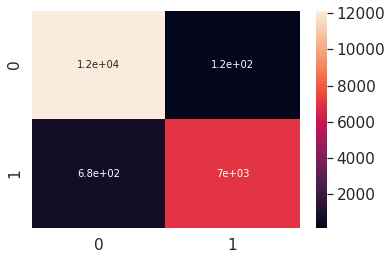

precision: 0.9834918858421936
recall: 0.9112119248217757
f1_score: 0.9459732220951356


In [0]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


probabilities = fully_trained.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

In [0]:
df_cm

,0,1
0,12129,118
1,685,7030


In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= .98 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .01):
      self.model.stop_training = True
call = myCallback()

model.fit(train_generator,
                    epochs = 5,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

Epoch 1/5
5087/5087 [==============================] - 1864s 366ms/step - loss: 0.0758 - accuracy: 0.9753 - recall: 0.9700 - precision: 0.9712 - auc: 0.9957 - auc_1: 0.9936 - val_loss: 0.0565 - val_accuracy: 0.9835 - val_recall: 0.9853 - val_precision: 0.9762 - val_auc: 0.9971 - val_auc_1: 0.9939
Epoch 2/5
5087/5087 [==============================] - 1882s 370ms/step - loss: 0.0797 - accuracy: 0.9758 - recall: 0.9701 - precision: 0.9721 - auc: 0.9959 - auc_1: 0.9936 - val_loss: 0.0391 - val_accuracy: 0.9861 - val_recall: 0.9832 - val_precision: 0.9841 - val_auc: 0.9988 - val_auc_1: 0.9985
Epoch 3/5
5087/5087 [==============================] - 1854s 364ms/step - loss: 0.0690 - accuracy: 0.9776 - recall: 0.9721 - precision: 0.9745 - auc: 0.9962 - auc_1: 0.9941 - val_loss: 0.0463 - val_accuracy: 0.9827 - val_recall: 0.9675 - val_precision: 0.9916 - val_auc: 0.9982 - val_auc_1: 0.9980
Epoch 4/5
5087/5087 [==============================] - 1938s 381ms/step - loss: 0.0695 - accuracy: 0.9789 

In [0]:
model.save('/content/drive/My Drive/Inception_fully_trained_V2')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Inception_fully_trained_V2/assets


In [0]:
from tensorflow.keras.models import load_model

#fully_trained = load_model('/content/drive/My Drive/Inception_fully_trained_V2')

test_gen = ImageDataGenerator(rescale = 1/255.)

test_generator = train_gen.flow_from_directory('/content/images/test',
                                                target_size=(200, 200),
                                                shuffle = False,
                                                 #batch_size=32,
                                                 class_mode = 'binary')


Found 19962 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


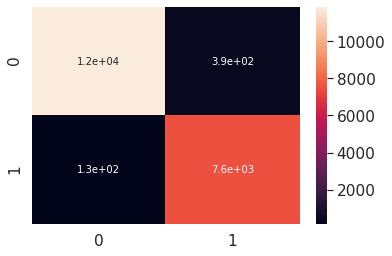

precision: 0.9514490026345502
recall: 0.9830200907323396
f1_score: 0.9669769220961367


In [0]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

In [0]:
df_cm

,0,1
0,11860,387
1,131,7584


## ResNet50V2


In [0]:
from tensorflow.keras.applications import ResNet50V2

pre_trained_model = ResNet50V2(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = 'imagenet')
pre_trained_model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 102, 102, 64) 0           conv1_conv[0][0]                 
________________________

In [0]:
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform

import datetime
%load_ext tensorboard



pre_trained_model.trainable = False # freezing all layers. if you want to freeze some of them select them or use for loop

#pre_trained_model.summary()
last_layer = pre_trained_model.output

X = layers.GlobalAveragePooling2D()(last_layer)
X = layers.Flatten()(X) # 2048
X = layers.Dense(1000, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(500, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(250, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)

log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model = Model(inputs = pre_trained_model.input, outputs = X)
#model.summary()


optim = optimizers.Adam(lr = .001)
model.compile(optimizer = optim,
              loss = 'binary_crossentropy',
              metrics=['accuracy',
                         Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= .97 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()

model.fit(train_generator,
                    epochs = 4,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])
model.save('resnet50V2')

Epoch 1/4
5087/5087 [==============================] - 1807s 355ms/step - loss: 0.2299 - accuracy: 0.9134 - recall: 0.9016 - precision: 0.8930 - auc: 0.9681 - auc_1: 0.9551 - val_loss: 0.1538 - val_accuracy: 0.9426 - val_recall: 0.9269 - val_precision: 0.9376 - val_auc: 0.9874 - val_auc_1: 0.9829
Epoch 2/4
5087/5087 [==============================] - 1792s 352ms/step - loss: 0.1972 - accuracy: 0.9276 - recall: 0.9214 - precision: 0.9074 - auc: 0.9764 - auc_1: 0.9661 - val_loss: 0.1447 - val_accuracy: 0.9431 - val_recall: 0.9359 - val_precision: 0.9309 - val_auc: 0.9874 - val_auc_1: 0.9837
Epoch 3/4
5087/5087 [==============================] - 1780s 350ms/step - loss: 0.1911 - accuracy: 0.9305 - recall: 0.9252 - precision: 0.9104 - auc: 0.9779 - auc_1: 0.9682 - val_loss: 0.1522 - val_accuracy: 0.9457 - val_recall: 0.9415 - val_precision: 0.9317 - val_auc: 0.9887 - val_auc_1: 0.9846
Epoch 4/4
5087/5087 [==============================] - 1787s 351ms/step - loss: 0.1870 - accuracy: 0.9323 

In [0]:
model.save('/content/drive/My Drive/resnet50V2')

INFO:tensorflow:Assets written to: /content/drive/My Drive/resnet50V2/assets


In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory('/content/images/test',
                                              shuffle=False, seed=42, target_size=(200, 200),
                                              batch_size=1, class_mode = 'binary')

Found 19962 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


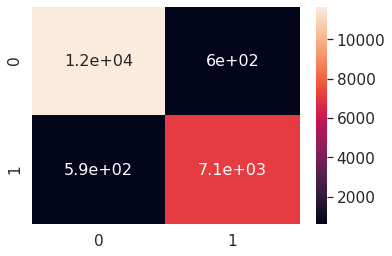

precision: 0.922449508026929
recall: 0.9235255994815295
f1_score: 0.9229872401062246


In [0]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score





probabilities = model.predict(test_gen)
y_true = test_gen.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

In [0]:
df_cm

,0,1
0,11648,599
1,590,7125


### Fine-tuning ResNet50V2

In [0]:
for idx,layer in enumerate(pre_trained_model.layers):
  print(idx, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad
46 

In [0]:
for layer in model.layers[:154]: # conv4_block6_out
  layer.trainable = False
for layer in model.layers[154:]:
  layer.trainable = True

In [0]:
%load_ext tensorboard

log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


#model.summary()
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > .97 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()

model.fit(train_generator,
                    epochs = 5,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])
model.save('/content/drive/My Drive/resnet50V2_tuned')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/5
5087/5087 [==============================] - 1789s 352ms/step - loss: 0.1826 - accuracy: 0.9342 - recall: 0.9284 - precision: 0.9158 - auc: 0.9800 - auc_1: 0.9713 - val_loss: 0.1353 - val_accuracy: 0.9473 - val_recall: 0.9490 - val_precision: 0.9287 - val_auc: 0.9889 - val_auc_1: 0.9848
Epoch 2/5
5087/5087 [==============================] - 1789s 352ms/step - loss: 0.1820 - accuracy: 0.9346 - recall: 0.9274 - precision: 0.9175 - auc: 0.9802 - auc_1: 0.9716 - val_loss: 0.1361 - val_accuracy: 0.9500 - val_recall: 0.9392 - val_precision: 0.9431 - val_auc: 0.9898 - val_auc_1: 0.9862
Epoch 3/5
5087/5087 [==============================] - 1786s 351ms/step - loss: 0.1794 - accuracy: 0.9364 - recall: 0.9292 - precision: 0.9200 - auc: 0.9807 - auc_1: 0.9726 - val_loss: 0.1547 - val_accuracy: 0.9495 - val_recall: 0.9386 - val_precision: 0.9424 - val_auc: 0.9894 - val_auc_1: 0.9852
Epoch 4/5
5087/5

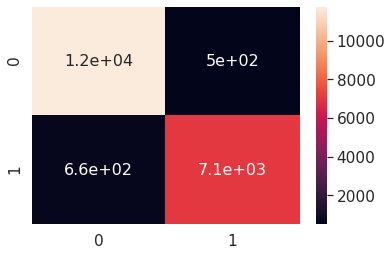

precision: 0.934322033898305
recall: 0.9145819831497084
f1_score: 0.9243466299862448


In [0]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score





probabilities = model.predict(test_gen)
y_true = test_gen.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

### Trying to train all the layers

In [0]:
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform

import datetime
%load_ext tensorboard

from tensorflow.keras.applications import ResNet50V2

pre_trained_model = ResNet50V2(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = 'imagenet')






pre_trained_model.trainable = True # unfreezing all layers. if you want to freeze some of them select them or use for loop

#pre_trained_model.summary()
last_layer = pre_trained_model.output

X = layers.GlobalAveragePooling2D()(last_layer)
X = layers.Flatten()(X) # 2048
X = layers.Dense(1000, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(500, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(250, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(50, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)

log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


model_all = Model(inputs = pre_trained_model.input, outputs = X)
#model.summary()


optim = optimizers.Adam(lr = .001)
model_all.compile(optimizer = optim,
              loss = 'binary_crossentropy',
              metrics=['accuracy',
                         Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= .97 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
model_all.fit(train_generator,
                    epochs = 4,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

Epoch 1/4
5087/5087 [==============================] - 2191s 431ms/step - loss: 0.1993 - accuracy: 0.9271 - recall_1: 0.9172 - precision_1: 0.9097 - auc_2: 0.9779 - auc_3: 0.9681 - val_loss: 0.0988 - val_accuracy: 0.9626 - val_recall_1: 0.9736 - val_precision_1: 0.9406 - val_auc_2: 0.9936 - val_auc_3: 0.9910
Epoch 2/4
5087/5087 [==============================] - 2176s 428ms/step - loss: 0.1408 - accuracy: 0.9496 - recall_1: 0.9413 - precision_1: 0.9388 - auc_2: 0.9881 - auc_3: 0.9822 - val_loss: 0.1549 - val_accuracy: 0.9454 - val_recall_1: 0.9933 - val_precision_1: 0.8910 - val_auc_2: 0.9933 - val_auc_3: 0.9877
Epoch 3/4
5087/5087 [==============================] - 2192s 431ms/step - loss: 0.1114 - accuracy: 0.9613 - recall_1: 0.9544 - precision_1: 0.9533 - auc_2: 0.9919 - auc_3: 0.9879 - val_loss: 0.0704 - val_accuracy: 0.9736 - val_recall_1: 0.9795 - val_precision_1: 0.9592 - val_auc_2: 0.9967 - val_auc_3: 0.9954
Epoch 4/4
5087/5087 [==============================] - 2154s 423ms/ste

In [0]:
model_all.save('/content/drive/My Drive/resnet50V2_fully_trained')

INFO:tensorflow:Assets written to: /content/drive/My Drive/resnet50V2_fully_trained/assets


Found 19962 images belonging to 2 classes.


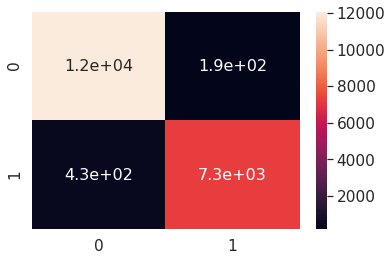

precision: 0.9749631811487481
recall: 0.9438755670771225
f1_score: 0.9591675447839831


In [0]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory('/content/images/test',
                                              shuffle=False, seed=42, target_size=(200, 200),
                                              batch_size=1, class_mode = 'binary')


probabilities = model_all.predict(test_gen)
y_true = test_gen.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

In [0]:
df_cm

,0,1
0,12060,187
1,433,7282


##### continue training

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale = 1/255.,
                               horizontal_flip = True,
                               zoom_range = [.8, 1.2],
                               brightness_range=[0.7,1.3]
                               )

valid_gen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_gen.flow_from_directory('/content/images/train',
                                                 target_size=(200, 200),
                                                 batch_size=32,
                                                 class_mode = 'binary')

valid_generator = valid_gen.flow_from_directory('/content/images/valid',
                                                 target_size=(200, 200),
                                                 batch_size=32,
                                                 class_mode = 'binary')

Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.


In [0]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, optimizers, Model, Input
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.initializers import glorot_uniform

import datetime
%load_ext tensorboard

log_dir = "/content/drive/My Drive/Colab Notebooks/face_class/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= .97 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True
call = myCallback()

model_all = load_model('/content/drive/My Drive/resnet50V2_fully_trained')

model_all.fit(train_generator,
                    epochs = 5,
                    validation_data = valid_generator,
                    steps_per_epoch = 5087,
                    validation_steps = 621,
                    callbacks=[tensorboard_callback, call])

Epoch 1/5
5087/5087 [==============================] - 2127s 418ms/step - loss: 0.1354 - accuracy: 0.9595 - recall_1: 0.9515 - precision_1: 0.9520 - auc_2: 0.9912 - auc_3: 0.9869 - val_loss: 0.0657 - val_accuracy: 0.9780 - val_recall_1: 0.9902 - val_precision_1: 0.9593 - val_auc_2: 0.9972 - val_auc_3: 0.9944
Epoch 2/5
5087/5087 [==============================] - 2142s 421ms/step - loss: 0.0767 - accuracy: 0.9745 - recall_1: 0.9692 - precision_1: 0.9701 - auc_2: 0.9956 - auc_3: 0.9934 - val_loss: 0.1516 - val_accuracy: 0.9521 - val_recall_1: 0.9905 - val_precision_1: 0.9057 - val_auc_2: 0.9924 - val_auc_3: 0.9836
Epoch 3/5
5087/5087 [==============================] - 2144s 421ms/step - loss: 0.1182 - accuracy: 0.9613 - recall_1: 0.9548 - precision_1: 0.9530 - auc_2: 0.9920 - auc_3: 0.9883 - val_loss: 0.0523 - val_accuracy: 0.9805 - val_recall_1: 0.9818 - val_precision_1: 0.9726 - val_auc_2: 0.9980 - val_auc_3: 0.9973
Epoch 4/5
5087/5087 [==============================] - 2144s 421ms/ste

In [0]:
model_all.save('/content/drive/My Drive/resnet50V2_fully_trained_V2') # best

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/resnet50V2_fully_trained_V2/assets


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Found 19962 images belonging to 2 classes.


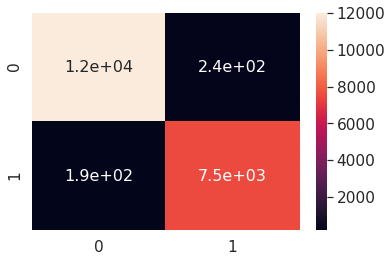

precision: 0.9684725260584224
recall: 0.97550226830849
f1_score: 0.9719746868138964


In [0]:
from tensorflow.keras.models import load_model
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score



test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory('/content/images/test',
                                              shuffle=False, seed=42, target_size=(200, 200),
                                              batch_size=1, class_mode = 'binary')


probabilities = model_all.predict(test_gen)
y_true = test_gen.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

In [0]:
df_cm

,0,1
0,12002,245
1,189,7526


# Grad-CAM

In [0]:
from tensorflow.keras.models import load_model
model_all = load_model('/content/drive/My Drive/resnet50V2_fully_trained_V2')

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
from tensorflow.keras.preprocessing import image



#model_all.summary()
img_size = (200, 200)

last_conv_layer_name = "conv5_block3_out"
classifier_layer_names = [
    "post_bn",
    "post_relu",
    "global_average_pooling2d_1",
    "flatten_1",
    "dense_5",
    "dropout_4",
    "dense_6",
    "dropout_5",
    "dense_7",
    "dropout_6",
    "dense_8",
    "dropout_7",
    "dense_9"
]

# The local path to our target image
import os
files = os.listdir('/content/images/test')


[[0.9997162]]
[[0.04066416]]
[[0.39004785]]
[[2.7304834e-22]]
[[0.00023623]]
[[1.4224234e-05]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


[[1.]]
[[0.0001747]]
[[0.00021501]]
[[0.99999166]]


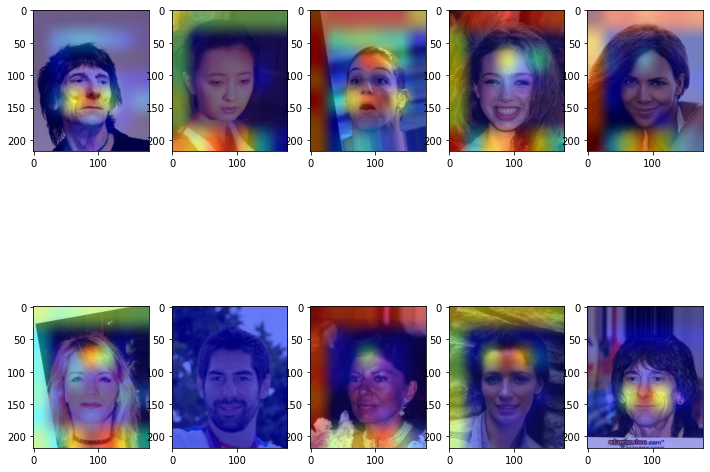

In [0]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def show(heat_map, img):
  heatmap = np.uint8(255 * heat_map)
  
  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.9 + img # 0.4
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
  plt.imshow(superimposed_img)

plt.figure(figsize = (12,10))
for i in range(len(files)):
  img = image.img_to_array(image.load_img('/content/images/test/' + files[i], target_size = (200,200)))
  img_normalized = img/255.
  img_add = np.expand_dims(img_normalized, axis=0)    
  heatmap = make_gradcam_heatmap(img_add, model_all, last_conv_layer_name, classifier_layer_names)
  img = keras.preprocessing.image.load_img('/content/images/test/' + files[i])
  img = keras.preprocessing.image.img_to_array(img)
  
  plt.subplot(2, 5,i+1)
  show(heatmap, img)
  print(model_all.predict(img_add))